# Investigation of COVID-19's origin and evolution with AI and Semantically inspired Knowledge Retrieval Framework (ASKRF)

#### Authors:
Anton Pols (anton.pols@roche.com), Guanya Peng (guanya.peng@roche.com), Kamran Farooq (kamran.farooq@roche.com), Markus Schmid (markus.schmid.ms3@roche.com), Vincent Wolowski (vincent.wolowski@roche.com)

## Task, Goal and Methodology
**AI and Semantically inspired Knowledge Retrieval Framework**

We developed a state of the art intelligent framework to extract the most scientifically relevant publications regarding COVID-19's origin and evolution and analyze and summarize information at sentence level by combining multiple advanced NLP techniques (BOW, TF-IDF, sentence embedding, BERT) and deep learning techniques.

Our framework is comprised of following key components:

**(a) NLP driven intelligent search engine**

We implemented a state of the art intelligent search engine based on the advanced machine learning and text mining techniques (TF-IDF, BOW and cosine similarity measures). In the first step, we filtered out and collated all relevant information for COVID-19, followed by the evaluation and score matching of extracted information and reviewing the search engine's final output (n-gram implementation).

**(b) Semantically inspired deep learning search engine**

In the second step, we developed semantically inspired deep learning based search engine with a view to extend the framework's ability to extend information extraction at the sentence level. Other key purpose was to dig out further insights into our refined queries, which represents our specific scientific interest in this area.

**(c) Knowledge graph based visualization**

In the third step, we deployed the knowledge graph method on the clustered sentences to visualize the top-level publications pertinent to various key entities. We carried out Sentence Segmentation, Entities Extraction and Relations Extraction operations to build our knowledge graph. We built these using limited entities due to time constrains to show its potential for the final scale up for future work.
The key selling point/benefit of our approach is its relatively robust modular implementation with high accuracy based on well-defined key words defined by the scientific expert in the team. This framework could provide the research community an efficient knowledge retrieval mechanism for studying COVID-19's origin and evolution. The framework could be extended to further enhance the information extraction mechanism and its representation through further enhancing knowledge graph implementation thereby providing noval outputs to the research community.


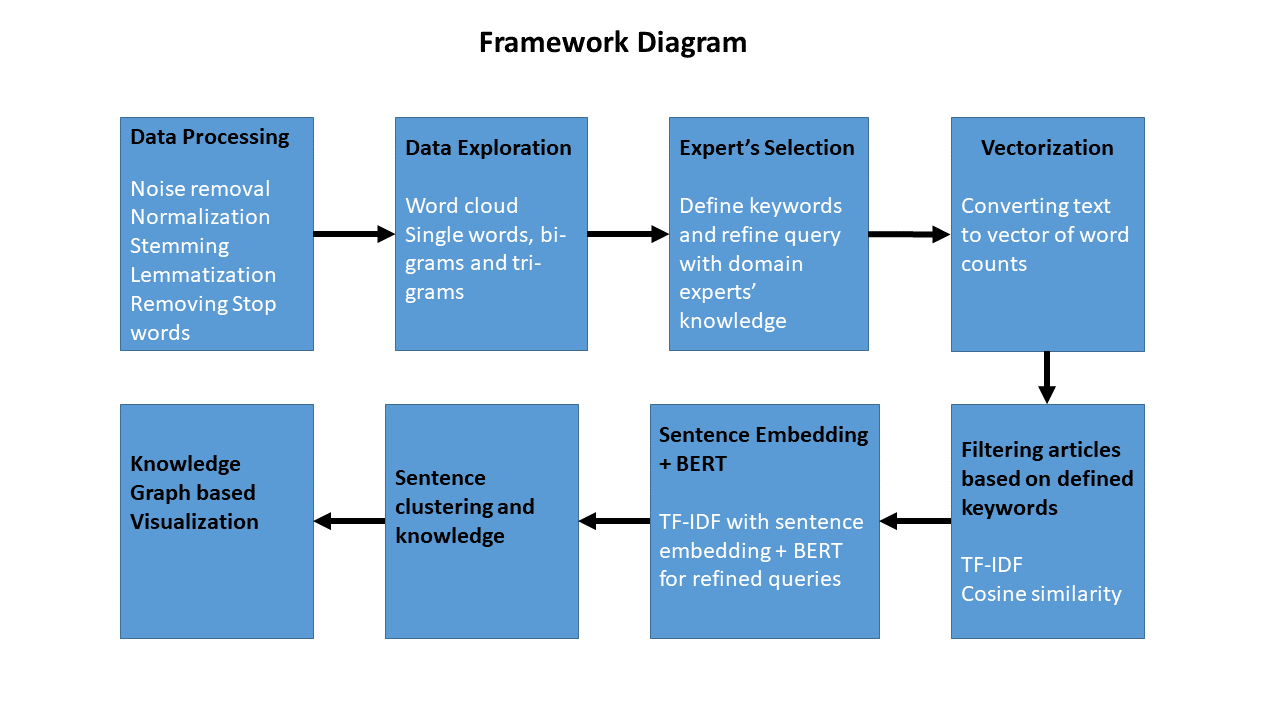

## Structure of our work and this notebook
- Data loading and merge meta information
- Pre-processing and tokenization
- Data exploration and simple keywords summary using word cloud and n-gram frequency
- Refine query and define key-words based on domain experts' knowledge
- TF-IDF
- Sentence embedding + BERT
- Results analysis, summarizing and knowledge retrieval with clustering and knowledge graph
- Conclusion and outlook

In [ ]:
# install packages
!pip install nltk --user
!pip install owlready2 --user
!pip install pronto --user
!pip install ipynb-py-convert --user
!pip install langdetect --user
!pip install contractions --user
!pip install inflect --user
!pip install num2words --user
!pip install tables --user
!pip install h5py --user
!pip install sentence-transformers --user
!pip install pandas --user
!pip install tqdm --user
!pip install seaborn --user
!pip install numpy --user
!pip install scipy --user
!pip install matplotlib --user
!pip install numpy --user
!pip install bottleneck --user
!pip install pandarallel --user
!pip install wordcloud --user
!pip install  --user spacy
!pip install --user https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

In [ ]:
from collections import defaultdict
import glob
import itertools
import json
import pickle
import os
import re

import bs4
import contractions
import inflect
from langdetect import detect
import matplotlib.pyplot as plt
import networkx as nx
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import tokenize
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
from pandarallel import pandarallel
from PIL import Image
import requests
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
from spacy.matcher import Matcher
from spacy.tokens import Span
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Initialize pandarallel
pandarallel.initialize(use_memory_fs=False,nb_workers=2)

In [ ]:
# pandas options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.options.mode.chained_assignment = None 

tqdm.pandas()

# make temp dir to save intermidiate data
if not os.path.exists('../data'):
    os.mkdir('../data')

## Data loading and merge meta information
Load meta data and all .json files and merge the meta information and article text into a single pandas DataFrame.

*Data loading approach is inspired by 
MaksimEkin and SoloNick following the very first part in [COVID-19 Literature Clustering](https://www.kaggle.com/maksimeren/covid-19-literature-clustering)*

We define some help functions here

In [ ]:
# Help functions and class
# help function to generate file path
def filepath(*args):
    if len(args) < 1:
        return None
    elif len(args) == 1:
        return args[0]
    else:
        return f'{args[0]}/{filepath(*args[1:])}'

# Add time bar to loop
def addtimebar(L, threshold=1000):
    if len(L) > threshold:
        return tqdm(L)
    else:
        return L

# File Reader Class
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            try:
                for entry in content['abstract']:
                    self.abstract.append(entry['text'])
            except KeyError:
                pass
                    
            # Body text
            try:
                for entry in content['body_text']:
                    self.body_text.append(entry['text'])
            except KeyError:
                pass
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'

# Helper function adds break after every words when character length reach to certain amount. This is for the interactive plot so that hover tool fits the screen.
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

## composition function
## example: compose(f1,f2,f3)(x, y) = f3(f2(f1(x, y)))
def compose(*funcs):
    *funcs, penultimate, last = funcs
    if funcs:
        penultimate = compose(*funcs, penultimate)
    return lambda *args: penultimate(last(*args))

In [ ]:
# file path
path = "../input/CORD-19-research-challenge"  # may need to change when submit to kaggle
meta = "metadata.csv"
# path for all json files
all_jsons = glob.glob(filepath(path, '**', '*.json'), recursive=True)

We read the metadata into a pandas dataframe. The metadata contains the following information. We will choose part of these information and merge with the actual text.
- cord_uid
- sha
- source_x
- title
- doi
- pmcid
- pubmed_id
- license
- abstract
- publish_time
- authors
- journal
- Microsoft Academic Paper ID
- WHO #Covidence
- has_full_text
- full_text_file
- url

In [ ]:
# data.frame for meta data
meta_df = pd.read_csv(filepath(path, meta),
                      dtype={'pubmed_id': str,
                             'Microsoft Academic Paper ID': str,
                             'doi': str,
                             'journal':str
                             },
                     low_memory=False)
print(len(meta_df)) # number of lines in meta_df_all
meta_df.head(n=2)

In [ ]:
# Have a look the first line of text data
first_row = FileReader(all_jsons[0])
print(first_row)

We now load all text data store in .json files in to a dataframe and merge with information from metadata

In [ ]:
# Load the text data into DataFrame
dict_ = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'publish_time':[], 'journal': [], 'abstract_summary': []}
for entry in addtimebar(all_jsons):
    content = FileReader(entry)
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['paper_id'].append(content.paper_id)
    dict_['abstract'].append(content.abstract)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 300 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # more than 2 authors, may be problem when plotting, so take first 2 append with ...
            dict_['authors'].append(". ".join(authors[:2]) + "...")
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add publish time
    try:
        publish_time = get_breaks(meta_data['publish_time'].values[0], 40)
        dict_['publish_time'].append(publish_time)
    # if publish time was not provided
    except Exception as e:
        dict_['publish_time'].append(meta_data['publish_time'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text', 'authors', 'title',  'journal', 'publish_time', 'abstract_summary'])
df_covid.head()

In [ ]:
# save data
df_covid.to_pickle('../data/df_kaggle_all.pkl')
# load saved data
# with open('../data/df_kaggle_all.pkl', 'rb') as fp:
#    df_covid = pickle.load(fp)

## Pre-processing and tokenization

### Select English articles
Since our analysis is based on English language, first check if documents are all in English with lib langdetect.
Go through each abstract and check the language.
Not all abstracts/documents are in English, e.g. some are in Spanish.
Exceptions are thrown in the case where we have URLs in the abstract column.
The following four cases in total:
- http://virus.zoo.ox.ac.uk/rnavirusdb
- http://hivweb.sanbi.ac.za/rnavirusdb
- http://bioinf.cs.auckland.ac.nz/rnavirusdb
- http://tree.bio.ed.ac.uk/rnavirusdb

We create a new dataframe which contains only the English documents.

In [ ]:
# function to check if text of certain column in dataframe is written in certain language 
def is_lang(row, item, lang, dropNA=True):
    if (row[item] != None and row[item] != '' and row[item] != 'None' and isinstance(row[item], str)):
        try:
            return detect(row[item]) == lang
        except Exception as e:
            #print("Non-readable entity will be droped from data.frame")
            return False
    else:
        return not dropNA

# select article written in certain language 
def select_article_lang_multi(df, basedon='abstract', lang='en'):
    return df[df.parallel_apply(lambda text: is_lang(text, basedon, lang), axis=1)]

df_covid_eng = select_article_lang_multi(df_covid)
print('Number of English Articles: {}/{}'.format(len(df_covid_eng), len(df_covid)))
df_covid_eng.head(n=2)

In [ ]:
# save intermidiate data
df_covid_eng.to_pickle('../data/df_kaggle_all_eng.pkl')
# load saved data
# with open('../data/df_kaggle_all_eng.pkl', 'rb') as fp:
#    df_covid_eng = pickle.load(fp)

### Text cleanning and tokenization
We process the data to clean the text with the following cleaning process and then tokenize both abstract and body_text with functionality in nltk package (nltk.word_tokenize). 
- Replace brackets
- Replace contractions
- Lower the case
- Replace commas
- Lemmatizing
- Stemming
- Remove number words
- Remove punctuations
- Remove stop words

We define a generic processor function which takes word-processors and text-processors and column name to clean the specific column in data frame with given processors. Users can easily change the word-processors and text-processors as function parameter and thus control the way how processing will be performed at both text and word level. Users can also easily choose which column in the dataframe to clean and tokenize. In principle, both abstract and body_text can be cleaned and tokenized easily with same function. For performance purpose, we only process abstract column. 

In [ ]:
# Pre-processing functions
## text level processors
def replace_brackets_with_whitespace(text):
    text = text.replace('(', '')
    text = text.replace(')', '')
    text = text.replace('[', '')
    text = text.replace(']', '')
    return text

def replace_contractions(text):
    return contractions.fix(text)

# remove special characters
def strip_characters(text):
    t = re.sub('\(|\)|:|,|;|\.|’||“|\?|%|>|<', '', text)
    t = re.sub('/', ' ', t)
    t = t.replace("'",'')
    return t

## word level processors:
def to_lowercase(word):
    return word.lower()

def do_stemming(stemmer):
    return lambda word: stemmer.stem(word)

def do_lemmatizing(lemmatizer):
    return lambda word: lemmatizer.lemmatize(word, pos='v') 

# help function to test if word is stopword
def is_stopword(word):
    return word in stopwords.words('english')

# function to process word
def process_word_by(word_cleanner, uniqueYN):
    def cond(word):
        return (len(word) > 1 and
                not is_stopword(word) and
                not word.isnumeric() and
                word.isalnum() and
                word != len(word) * word[0])

    def clean_byword(text):
        return list(take_unique(uniqueYN)((word_cleanner(word) for word in text if cond(word))))

    return clean_byword

# function to decide making a set (unique words) from text or not
def take_unique(YN):
    return set if YN else lambda x:x

# function to pre_processing the text
## compose text and word processors by combine every individual processor together 
text_processor = compose(replace_brackets_with_whitespace, replace_contractions, strip_characters)
word_processor = compose(to_lowercase, do_lemmatizing(WordNetLemmatizer()), do_stemming(PorterStemmer())) # it is crucial to do stemming after lemmatization

## pre_processing function taking a dataframe and text and word processor functions as input and clean the text and tokenize the specified column
def pre_processing(df, text_tools, word_tools):
    def inner(col, uniqueYN=False):
        return df[col].parallel_apply(text_tools).parallel_apply(nltk.word_tokenize).parallel_apply(process_word_by(word_tools,uniqueYN=uniqueYN))
    return inner

In [ ]:
# sort by publish time
tokenized_df = df_covid_eng.sort_values(by='publish_time', ascending=False)
tokenized_df.head(n=3)

In [ ]:
# created processor function with chosen text and work processors and apply it to all articles to clean and tokenize all abstracts
processor = pre_processing(tokenized_df, text_processor, word_processor)
tokenized_df['abstract_token'] = processor('abstract')

# reset index (this is necessary for cosine similarity search)
tokenized_df = tokenized_df.reset_index(drop=True)

# Our processor function is a generic procedure to clean and tokenize any column with user specified column name, such as 'abstract' or 'body_text'
# Because processing body_text takes too long, we only process abstract
# tokenized_df['body_text_token'] = processor('body_text')

In [ ]:
# store the dataframe to ../data/
tokenized_df.to_pickle('../data/df_kaggle_all_eng_tokenized.pkl')
# with open('../data/df_kaggle_all_eng_tokenized.pkl', 'rb') as fp:
#    tokenized_df = pickle.load(fp)

# have a look at the head of the cleanned and tokenized abstract column
tokenized_df.head()['abstract_token']

In [ ]:
tokenized_df.head()

## Data exploration and keywords summary using word cloud and n-gram frequency
### Word cloud
We will now visualize the text corpus that we created after pre-processing to get insights on the most frequently used words.

In [ ]:
# create corpus
tokenized_df['abstract_corpus'] = tokenized_df['abstract_token'].apply(lambda tokens: ' '.join(tokens))
corpus = tokenized_df['abstract_corpus'].tolist()

#Word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords.words('english'),
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(' '.join(corpus))
fig = plt.figure(1)
fig.set_size_inches(15,12)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Visualize top N uni-grams, bi-grams & tri-grams using vector of word counts
We then create vector of word counts based on bag of words model, which ignores the sequence of the words and only considers word frequencies. Using the vector we created we then evoke the fit_transform function to learn and build the vocabulary and this allows us to visualize the top 20 unigrams, bi-grams and tri-grams and gain insight from overall articles.

In [ ]:
# Function to get top n-grams
def get_top_nK_words(corpus, K=1, n=None):
    vec1 = CountVectorizer(max_df=0.7,stop_words=stopwords.words('english'), ngram_range=(K,K),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

#### Top Uni-grams

In [ ]:
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_nK_words(corpus, K=1, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
#Barplot of most freq words
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

#### Top Bi-grams

In [ ]:
# Top bi-grams
top2_words = get_top_nK_words(corpus, K=2, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)
#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)
fig = h.get_figure()

#### Top Tri-grams

In [ ]:
top3_words = get_top_nK_words(corpus, K=3, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)
fig = j.get_figure()

## Refine query and define key-words

Combining results of our data exploration and domain expert knowledge, we thus defined keywords and refined some query. This allows us to dig into our data towards more specific target and thus extract more relevant information for our specific scientific interests.

For the first query, we focused on animal host(s) and any evidence of continued spill-over to humans: Our initial approach was led by the following guiding principle: Start simple to check our model. MERS had a very limited outbreak in Saudi-Arabia with a very defined animal as a virus source - the dromedary camels. Also, the timing was very defined. Infections took place during the year 2012. We have a publication describing all the publications about MERS. This might help us to understand the result. 

There is e.g. a difference between African & Arabian dromedaries regarding the infection. Keywords for first run: MERS-CoV; MERS, EMC/2012, HCoV-EMC/2012, dromedary camels, zoonotic, african,  spill-over, spillover, transmission, infection, human, species, progenitor, precursor, host. The results were reviewed by a domain expert and verified the adopted strategy. For the second query, we shifted the focus on a broader topic. This time, we looking into SARS-CoV2 and any evidence of continued spill-over to humans. 

Guiding principle: First approach showed the power of the individual approaches. Keyword filtering is a great method for efficient selection of high-quality content, but lacks the identification of important sentences. Sentence embedding has its strengths there. 

Thereby, those are now combined with tokenization of all publications, with a focus on COVID-19. Keywords for second run: SARS-CoV-2, Covid-19, HCoV-19, Covid, corona, 2019-nCoV, sars cov2, 2019 ncov, coronavirus 2\b, coronavirus 2019, wuhan coronavirus, coronavirus disease 19, ncov 2019, wuhan pneumonia, 2019 nov, Infection, spill-over, diagnosis, death, emergence, respiratory samples, diagnosed, mortality, transmission, Evolution, adaption, selection, species, progenitor, precursor, common ancestor, host, Cow, bird, cat, dromedary camels, Zoonotic, ferrets, bat, Pangolin, wildlife, animals, livestock. 

Query for sentence embedding: "Evidence of animal infection with SARS-CoV-2 and its transmission to other hosts, including the spill-over to humans".


## TF-IDF

We implement a search engine based on TF-IDF and cosine similarity with bag of word model. A high weight in TF-IDF is reached when we have high term frequency in the given document and the low document frequency of the term in the whole collection of documents. Thus, TF-IDF helps to find frequent issues in the reviews that are not so frequent in the whole data-set, so specific issues and we want to highlight them.

The benefit of this method is relatively high accuracy with well-defined key-words. However, its power to extend the information extraction and obtain some noval output is limited. We will use this technical plus domain expert's knowledge as first step to filter-out and pool all relevant information for COVID19 and evaluate the matching score and review the output. With the pooled dataset, we apply then a more semantics approach with sentence embedding incorporate the power of deep learning to extend our ability of information extraction and dig out more insight towards our refined query, which represents our specific scientific interest.

### Compute TF-IDF for word vectors
We first compute TF-IDF scores based on word vectors

In [ ]:
# compute TF-IDF scores for word vectors
def tfidf_(df):
    myvectorizer = TfidfVectorizer()
    vectors = myvectorizer.fit_transform(df['abstract_token'].parallel_apply(lambda x:' '.join(x))).toarray()
    feature_names = myvectorizer.get_feature_names()
    veclist = vectors.tolist()
    out_tfidf = pd.DataFrame(veclist, columns=feature_names)
    return out_tfidf

tfidf_(tokenized_df[:20]).head()

### Investigate words with highest TF-IDF scores in the vectors
We then investigate the words with top TF-IDF scores and get some insight of our vocabulary.

In [ ]:
# using sklearn is 10 times faster than self-written script
# extract key-words with tfidf score
tfidf_scores_df = tfidf_(tokenized_df[:20])
N = 15 # Number of min/max values 
u = np.argpartition(tfidf_scores_df, axis=1, kth=N).values
v = tfidf_scores_df.columns.values[u].reshape(u.shape)
maxdf = pd.DataFrame(v[:,-N:]).rename(columns=lambda x: f'Max{x+1}')
maxdf.head()

### Implement search engine with cosine similarity based on TF-IDF scores

We implement then a search engine using cosine similarity bewteen the query vector and our vocabulary. The matching score is based on TF-IDF we computed for our word vectors.

In [ ]:
# convert query token to vector
def gen_vector_T(tokens):
    Q = np.zeros((len(vocabulary)))    
    x= tfidf.transform(tokens)
    #print(tokens[0].split(','))
    for token in tokens[0].split(','):
        #print(token)
        try:
            ind = vocabulary.index(token)
            Q[ind]  = x[0, tfidf.vocabulary_[token]]
        except:
            pass
    return Q

# calculate cosine similarity
def cosine_sim(a, b):
    cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos_sim

# Function to get transformed tfidf model
def tfidf_tran(mydf):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(mydf['abstract_token'].parallel_apply(lambda x:' '.join(x)))
    return vectors

# Define wordLemmatizer
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
def wordLemmatizer(data):
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    file_clean_k =pd.DataFrame()
    for index,entry in enumerate(data):
        
        # Declaring Empty List to store the words that follow the rules for this step
        Final_words = []
        # Initializing WordNetLemmatizer()
        word_Lemmatized = WordNetLemmatizer()
        # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
        for word, tag in nltk.pos_tag(entry):
            # Below condition is to check for Stop words and consider only alphabets
            if len(word)>1 and word not in stopwords.words('english') and word.isalpha():
                word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
                Final_words.append(word_Final)
            # The final processed set of words for each iteration will be stored in 'text_final'
                file_clean_k.loc[index,'Keyword_final'] = str(Final_words).lower()
                file_clean_k=file_clean_k.replace(to_replace ="\[.", value = '', regex = True)
                file_clean_k=file_clean_k.replace(to_replace ="'", value = '', regex = True)
                file_clean_k=file_clean_k.replace(to_replace =" ", value = '', regex = True)
                file_clean_k=file_clean_k.replace(to_replace ='\]', value = '', regex = True)
    return file_clean_k

In [ ]:
def cosine_similarity_T(k, query, text_token_df):
    preprocessed_query  = re.sub("\W+", " ", query).strip()
    tokens = nltk.word_tokenize(text_processor(str(preprocessed_query).lower()))
    tokens = [word_processor(token) for token in tokens if 
              len(token) > 1 and
              not is_stopword(token) and
              not token.isnumeric() and
              token.isalnum() and
              token != len(token) * token[0]]
    q_df = pd.DataFrame(columns=['q_clean'])
    q_df.loc[0,'q_clean'] =tokens
    q_df['q_clean'] = wordLemmatizer(q_df.q_clean)
    d_cosines = []
    #print(q_df['q_clean'])
    query_vector = gen_vector_T(q_df['q_clean'])
    #print(query_vector)
    #print(q_df['q_clean'])
    #print(sum(query_vector))
    for d in tfidf_tran.A:
        d_cosines.append(cosine_sim(query_vector, d))
    #print(d_cosines)              
    out = np.array(d_cosines).argsort()[-k:][::-1]
    d_cosines.sort()
    #print(out)
    a = pd.DataFrame()
    firsttime=True
    for i,index in enumerate(out):
        try:
            a.loc[i, 'Paper ID'] = text_token_df['paper_id'][index]
            a.loc[i,'Title'] = text_token_df['title'][index]
            a.loc[i, 'Summary'] = text_token_df['abstract_summary'][index]
        except KeyError as e:
            if firsttime:
                print("Fewer matches are found than requested {}".format(k))
                firsttime=not firsttime
                pass
    for j,simScore in enumerate(d_cosines[-k:][::-1]):
        a.loc[j,'Score'] = simScore
    return a

### Apply TF-IDF search engine with keywords defined using expert's domain knowledge
The goal is to extract more relevant information and limit our investigation space within the range of COVID-19 related articles. Before applying it to COVID-19 related keywords, we also tried using MERS related keywords for a relatively smaller dataset and evaluate the results. Although the recall is limited, the accuracy we obtained is quite high. There is always a trade-off between accuracy and recall. As we are interested into a specific scientific question, our requirement with accuracy is high and with relatively large dataset and power of sentence embedding we will add later the limit of recall can be compensated.

The matching score based on TF-IDF and cosine similarity provides us a quantitative way to evaluate our search. We sort all articles based on the matching score and obtain a list of the most relevant articles.

In [ ]:
## Create Vocabulary
vocabulary = set()
for tokens in tokenized_df.abstract_token:
    vocabulary.update(tokens)
vocabulary = list(vocabulary) 

# Intializating the tfIdf model
tfidf = TfidfVectorizer(vocabulary=vocabulary)

# Transform the TfIdf model
tfidf_tran=tfidf.fit_transform(tokenized_df['abstract_token'].parallel_apply(lambda x:' '.join(x)))

# search engine using cosine similarity + TF-IDF
TFIDF_output = cosine_similarity_T(20000,'SARS-CoV-2 Covid-19 HCoV-19 Covid corona 2019-nCoV sars cov2 ncov wuhan coronavirus pneumonia',tokenized_df)
TFIDF_output_significant = TFIDF_output[TFIDF_output['Score'] > 0]
TFIDF_output_significant.head()

In [ ]:
# store the dataframe to ../data/
TFIDF_output_significant.to_pickle('../data/TFIDF_output_significant_all.pkl')

# The amount of the most significant search results
len(TFIDF_output_significant)

## Sentence embedding + BERT

Word embedding is a method based on neural networks to obtain for every word in a sentence a (context dependent) vectorized representation. This representation allows comparison of words in embedding space: words closely spaced together have a similar meaning and/or connotation, while words far apart are very dissimilar. Recent state-of-the-art models such as BERT have proven to be very good at obtaining relevant word embeddings for practical applications such as language translation. Recently, methods have been developed to use these state-of-the-art models to obtain embeddings for whole sentences. Here, we are using the method as described by Nils Reimers and Iryna Gurevych (https://arxiv.org/abs/1908.10084). They have open sourced their code and provide a Python package, which we are using here (https://github.com/UKPLab/sentence-transformers).

We are embedding every sentence of the papers that have been marked as interesting by the TF-IDF search engine. We do this for the abstracts of the papers as well as the combined text (abstract + body text) of the papers. Subsequently, we embed a constructed sentence made by us. This sentence can be viewed as the query: it contains keywords that we want to know more about from the literature we are searching.

After embedding the sentences of the abstracts, combined text and sentence query, we compare every sentence in the abstracts and combined text to the sentence query in embedding space. To do this comparison we are using the cosine similarity measure and after comparing, we have a score for every sentence in the abstracts and combined text. A high score (close to 1) means that the compared sentences are very similar, a low score (close to 0) means that they are very dissimilar, so in this case a high score means that the compared sentence in the paper's abstract or body text is very comparable to the sentence query. Subsequently, we rank the sentences based on their score and we keep the top 50 sentences for both the abstracts and combined text. We then find the associated paper id and text of the paper for every sentence in the top 50 and store the results for human evaluation.

Here we load the data stored by the TF-IDF search engine, only get the papers that it found and for the sentences of those papers we obtain and store the sentence embeddings.

In [ ]:
get_top = 500
top_to_print = 10

#with open('../data/TFIDF_output_significant_all.pkl', 'rb') as fp:
#    TFIDF_output_significant = pickle.load(fp)
with open('../data/df_kaggle_all_eng.pkl', 'rb') as fp:
    df_covid_eng = pickle.load(fp)

df_covid_eng.drop_duplicates(subset=['paper_id'], inplace=True)    
TFIDF_output_significant.drop_duplicates(subset=['Paper ID'], inplace=True)

papers_to_embed = df_covid_eng.loc[df_covid_eng['paper_id'].isin(
    TFIDF_output_significant['Paper ID'])].copy()

sort_papers = TFIDF_output_significant.loc[
    TFIDF_output_significant['Paper ID'].isin(
        papers_to_embed['paper_id'])].sort_values(
    by='Score', ascending=False)['Paper ID'].to_list()
papers_to_embed = papers_to_embed.set_index('paper_id').loc[sort_papers].reset_index()

In [ ]:
tqdm.pandas(desc='Combining abstracts and body text')
papers_to_embed['combined_text'] = papers_to_embed.progress_apply(
        lambda x: x['abstract'] + ' ' + x['body_text'], axis=1)

tqdm.pandas(desc='Splitting abstracts into sentences')
papers_to_embed['abstract_sentence'] = papers_to_embed[
    'abstract'].progress_apply(tokenize.sent_tokenize)
    
tqdm.pandas(desc='Splitting papers into sentences')
papers_to_embed['combined_text_sentence'] = papers_to_embed[
    'combined_text'].progress_apply(tokenize.sent_tokenize)

In [ ]:
embedder = SentenceTransformer('bert-base-nli-mean-tokens')

sent_to_embed_abstr = list(itertools.chain(
    *papers_to_embed['abstract_sentence']))
sent_to_embed_comb = list(itertools.chain(
    *papers_to_embed['combined_text_sentence'].iloc[:get_top]))

abstract_embed = np.array(embedder.encode(
    sent_to_embed_abstr, batch_size=64, show_progress_bar=True))
comb_text_embed = np.array(embedder.encode(
    sent_to_embed_comb, batch_size=64, show_progress_bar=True))

In [ ]:
# save intermidiate data in case needed
np.save('../data/abstr_data_encodings', abstract_embed)
np.save('../data/comb_text_data_encodings', comb_text_embed)

Here we load the sentence embeddings and we embed our sentence query. 

In [ ]:
# load intermidiate data in case needed
# abstract_embed = np.load('../data/abstr_data_encodings.npy')
# comb_text_embed = np.load('../data/comb_text_data_encodings.npy')

In [ ]:
questions = [
    ('Evidence of animal infection with SARS-CoV-2 and its transmission to '
     'other hosts, including the spill-over to humans.')
]

questions_embed = np.array(embedder.encode(
    questions, batch_size=64, show_progress_bar=True))

Here we compare every sentence in the abstracts and combined text to the sentence query in embedding space using the cosine similarity measure. Subsequently, we rank the sentences based on their cosine similarity measure and we keep the top 50 sentences for both the abstracts and combined text. We then find the associated paper id and text of the paper for every sentence in the top 50 and store the results for human evaluation.

In [ ]:
similarity_abstr = cosine_similarity(
    abstract_embed, questions_embed).squeeze()
similarity_comb = cosine_similarity(
    comb_text_embed, questions_embed).squeeze()

sort_args_abstr = np.argsort(similarity_abstr)[::-1]
sim_sort_abstr = similarity_abstr[sort_args_abstr]
sort_args_comb = np.argsort(similarity_comb)[::-1]
sim_sort_comb = similarity_comb[sort_args_comb]

paper_id_abst = np.array(list(itertools.chain(
    *papers_to_embed.progress_apply(
        lambda x: [x['paper_id']] * len(x['abstract_sentence']), 
        axis=1).tolist())))
paper_id_comb = np.array(list(itertools.chain(
    *papers_to_embed.iloc[:get_top].progress_apply(
        lambda x: [x['paper_id']] * len(x['combined_text_sentence']), 
        axis=1).tolist())))

interest_paper_id_abstr = paper_id_abst[sort_args_abstr]
interest_sentences_abstr = np.array(
    sent_to_embed_abstr)[sort_args_abstr]
interest_abstracts = papers_to_embed.set_index('paper_id').loc[
    interest_paper_id_abstr]['abstract'].tolist()

interest_paper_id_comb = paper_id_comb[sort_args_comb]
interest_sentences_comb = np.array(
    sent_to_embed_comb)[sort_args_comb]
interest_comb_text = papers_to_embed.set_index('paper_id').loc[
    interest_paper_id_comb]['combined_text'].tolist() 

with open('interesting_papers_based_on_abstract.txt', 'w') as f:
    for paper, sent, abst, metric in zip(
        interest_paper_id_abstr, interest_sentences_abstr, interest_abstracts, sim_sort_abstr):
        _ = f.write('Paper ID: ' + paper + '\n')
        _ = f.write('Important sentence: ' + sent + '\n')
        # _ = f.write('Associated abstract: ' + abst + '\n')    
        _ = f.write('Cosine Similarity metric: ' + '{0:.3f}'.format(metric) + '\n')
        _ = f.write('\n')       
        
with open('interesting_papers_based_on_comb_text.txt', 'w') as f:
    for paper, sent, comb_text, metric in zip(
        interest_paper_id_comb, interest_sentences_comb, interest_comb_text, sim_sort_comb):
        _ = f.write('Paper ID: ' + paper + '\n')
        _ = f.write('Important sentence: ' + sent + '\n')
        _ = f.write('Cosine Similarity metric: ' + '{0:.3f}'.format(metric) + '\n')
        # _ = f.write('Associated body text: ' + comb_text + '\n')    
        _ = f.write('\n')        

Here we print the results for human evaluation.

In [ ]:
print('Results based on abstract:')
print('"""')
with open('interesting_papers_based_on_abstract.txt', 'r') as f:
    print('\n'.join(f.read().splitlines()[:4*top_to_print]))
print('"""') 
print('')
print('Results based on abstract and body text:')
print('"""')    
with open('interesting_papers_based_on_comb_text.txt', 'r') as f:
    print('\n'.join(f.read().splitlines()[:4*top_to_print]))
print('"""')    

## Results analysis, information summarization and knowledge retrieval
To better understand our results out of the final sentence embedding step and summarize the information we obtained, we first cluster the sentences and draw knowledge graph to visualize the key logic behind the high score sentences selected by our model. It helps us to understand better the behavior of our model and helps to dig some hidden knowledge out of our results.

### Sentence embedding clustering

It is possible to cluster the embedded sentences in embedding space and print sentences associated with each found cluster for human evaluation.

In [ ]:
rows_to_sample = np.random.randint(len(comb_text_embed), size=1000)

sentences_subset = np.array(sent_to_embed_comb)[rows_to_sample].tolist()
embeddings_subset = comb_text_embed[rows_to_sample] 

# Perform kmean clustering
num_clusters = 5
clustering_model = KMeans(n_clusters=num_clusters)
_ = clustering_model.fit(embeddings_subset)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(sentences_subset[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster[:10])
    print("")

### Visualization by knowledge graph
The outcome of the sentence embedding can be handily visualized using the concept of a knowledge graph where top ranked sentences are decomposed into a set of nodes and edges to represent important relationships between entities. Those entities were identified by parts of speech (POS) tags and parsing out the dependency tree of the sentence, such as nouns for example are treated as nodes and verbs as relationships. To extract more complex relationships is an ongoing effort in our NLP pipeline.

In [ ]:
file_to_read = './interesting_papers_based_on_comb_text.txt'
content = None
with open(file_to_read) as f:
    content = f.readlines()
content = [x.strip() for x in content] 
content = [string for string in content if string != ""]
top_results = content[0:100] # Select the first n elements.
selected_top_sentences = []
for elem in top_results:
    if elem.startswith('Important sentence:'):
        selected_top_sentences.append(elem.replace('Important sentence:','').strip())
# Select the first n sentences.
selected_top_sentences = selected_top_sentences[0:20]

# Some settings for the plot.
pd.set_option('display.max_colwidth', 200)

# The main idea is to go through a sentence and extract the subject and the object 
# as and when they are encountered.
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""
    prv_tok_dep = ""  # dependency tag of previous token in the sentence
    prv_tok_text = ""  # previous token in the sentence
    prefix = ""
    modifier = ""
    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text
            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text
            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""
            ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " " + tok.text
            ## chunk 5
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
    return [ent1.strip(), ent2.strip()]

# Relation/Predicate Extraction.
# The hypothesis is that the predicate is actually the main verb in a sentence.
def get_relation(sent):
  doc = nlp(sent)
  # Matcher class object
  matcher = Matcher(nlp.vocab)
  #define the pattern
  pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},
            {'POS':'ADJ','OP':"?"}]
  matcher.add("matching_1", None, pattern)
  matches = matcher(doc)
  k = len(matches) - 1
  span = doc[matches[k][1]:matches[k][2]]
  return(span.text)

entity_pairs = []

for i in tqdm(selected_top_sentences):
  entity_pairs.append(get_entities(i))

# extract relationship
relations = [get_relation(i) for i in tqdm(selected_top_sentences)]
print(relations)

# extract subject
source = [i[0] for i in entity_pairs]
print(source)

# extract object
target = [i[1] for i in entity_pairs]
print(target)

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

# Use the library networkx to build graph.
# Create a directed graph from the dataframe first.
sentence_graph = nx.from_pandas_edgelist(kg_df, 
                                         "source", 
                                         "target",
                                         edge_attr=True, 
                                         create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,9)) # Change this to make plotting area for knowledge graph bigger or smaller.
# For parameters of spring_layout, see 
# https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html
#pos = nx.spring_layout(sentence_graph)
pos = nx.spring_layout(sentence_graph,
                      k = 1.3,
                      iterations = 100,
                      fixed = None,
                      center = (0,0),
                      scale = 4)
nx.draw(sentence_graph, 
        with_labels=True, 
        node_color='skyblue', 
        edge_cmap=plt.cm.Blues, 
        pos=pos)
plt.show()

## Conclusion and outlook

### How domain experts’ knowledge and data science/AI worked hand in hand
As part of this short analytics journey, we have followed all phases in the data science/analytics life cycle. In this time-constrained activity, we have deployed state of the art advanced NLP and machine learning techniques to develop an intelligent knowledge retrieval framework to study COVID-19's origin and evolution. The proposed framework will facilitate the research community to retrieve key (top level) publications by specifying most frequently used COVID-19 scientific keywords and perform semi-automatic analysis at sentence level to dig out hidden knowledge and noval information. We have demonstrated the framework's utilization and effectiveness by way of utilizing high-level keywords specified by the subject matter expert in the team. In the end, we have provided a 360 view of the acquired publications through Knowledge Graph component for ease of use for the research community.